In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np
import cv2
import time
import random
import torchvision
import random
import cv2
import gc
import os

In [4]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [5]:
print(model.eval())

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

)


In [6]:
def randomColor(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [7]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [8]:
class prediction():
    def __init__(self,image_path,threshold,mask=True):
        
        self.mask       = mask
        self.image      = image_path
        self.threshold  = threshold
        self.img        = Image.open(self.image)
        self.transform  = T.Compose([T.ToTensor()])
        self.img        = self.transform(self.img)
        self.start      = time.time()
        self.pred       = model([self.img])
        self.end        = time.time() - self.start
        self.pred_score = list(self.pred[0]['scores'].detach().numpy())
        print("-"*50)
        print(self.pred_score)
        
        print("-"*50)
        try:
            self.pred_t     = [self.pred_score.index(x) for x in self.pred_score if x> threshold][-1]
            self.shortlist  = [x for x in self.pred_score if x > threshold]
        except IndexError:
            self.pred_t = self.pred_score.index(max(self.pred_score))
            self.shortlist = [max(self.pred_score)]
            print("DD:",self.pred_t)
        self.pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(self.pred[0]['labels'].numpy())]
        if(self.mask == True):
            self.masks  = (self.pred[0]['masks']>threshold).squeeze().detach().cpu().numpy()
            self.masks  = self.masks[:self.pred_t+1]
        
        
        self.pred_boxes = [[(i[0],i[1]),(i[2],i[3])] for i in list(self.pred[0]['boxes'].detach().numpy())]
        self.pred_boxes = self.pred_boxes[:self.pred_t+1]
        self.pred_class = self.pred_class[:self.pred_t+1]

    def combine(self,show_image=False,rect_th=3,text_size=1.5,text_th=3,save_img=False):
        
        self.cv2_img   = cv2.imread(self.image)
        self.cv2_img   = cv2.cvtColor(self.cv2_img,cv2.COLOR_BGR2RGB)
        if(self.mask== True):
            
            for i in range(len(self.masks)):
                rgb_mask = randomColor(self.masks[i])
                self.cv2_img = cv2.addWeighted(self.cv2_img,1,rgb_mask,0.5,0)
                boxes = self.pred_boxes[i]
                pred_name = self.pred_class[i]
                score = (self.shortlist)[i]
                # img, start point, end point, color, thickness
                cv2.rectangle(self.cv2_img, boxes[0], boxes[1],color=(0, 255, 0), thickness=rect_th)
                cv2.putText(self.cv2_img,pred_name+": "+str(score)+"%", boxes[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
            
            
        else:
            self.cv2_img = self.cv2_img
            for i in range(len(pred.pred_class)):
                #label_num = pred.pred_class.index(i)
                boxes = self.pred_boxes[i]
                pred_name = self.pred_class[i]
                score = (self.shortlist)[i]
                
                # img, start point, end point, color, thickness
                cv2.rectangle(self.cv2_img, boxes[0], boxes[1],color=(0, 255, 0), thickness=rect_th)
                cv2.putText(self.cv2_img,pred_name+": "+str(score)+"%", boxes[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
                
        if(show_image==True):
            print(self.end)
            plt.figure(figsize=(20,30))
            plt.imshow(self.cv2_img)
            plt.xticks([])
            plt.yticks([])
            plt.show()

        return self.cv2_img
    

--------------------------------------------------
[0.9972235, 0.9955983, 0.99436426, 0.9931565, 0.9926944, 0.9904524, 0.98983395, 0.9891828, 0.9657665, 0.96471554, 0.9549503, 0.92968416, 0.925048, 0.87999135, 0.86761147, 0.86674035, 0.82780343, 0.8272975, 0.76316416, 0.72572976, 0.66501063, 0.5929185, 0.58867514, 0.53306216, 0.50576055, 0.47440436, 0.4675637, 0.4003824, 0.38266152, 0.36001837, 0.3484004, 0.32214692, 0.29390445, 0.27196294, 0.19891654, 0.19221345, 0.16606417, 0.16146265, 0.15737475, 0.15045424, 0.14566259, 0.14058754, 0.13908608, 0.114944816, 0.100082435, 0.09991613, 0.094168834, 0.08901114, 0.08400149, 0.07301498, 0.07299726, 0.066958636, 0.06603376, 0.06300674, 0.056717347, 0.056117527, 0.05568629, 0.05353022, 0.0533326, 0.050222687]
--------------------------------------------------
DD: 0
12.766698360443115


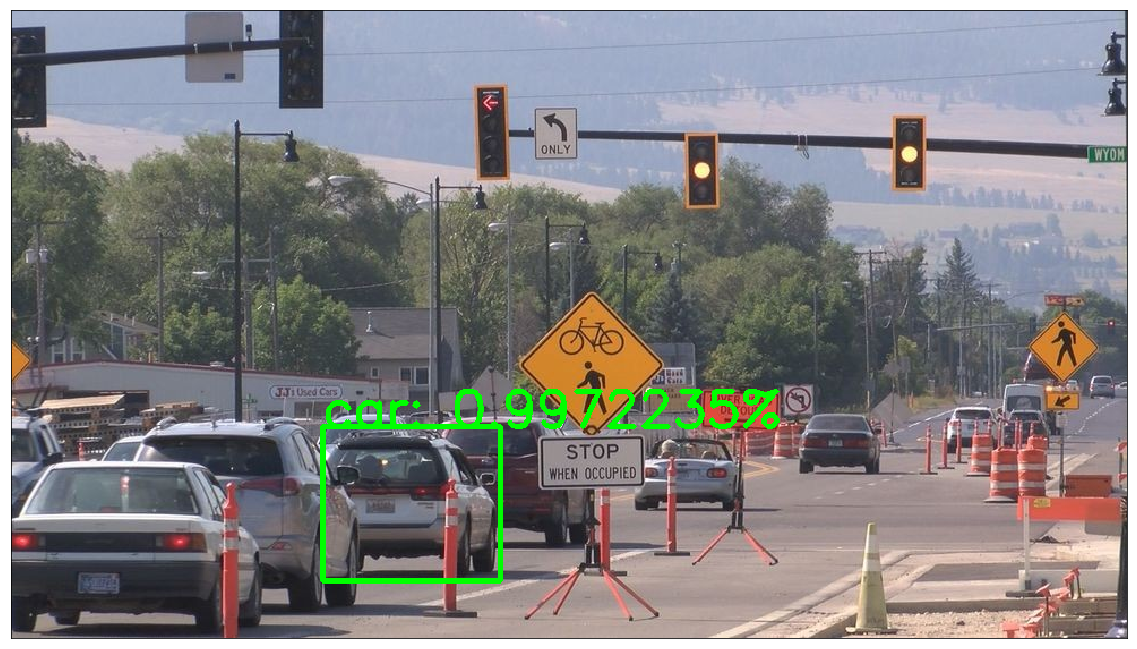

array([[[162, 174, 200],
        [162, 174, 200],
        [162, 174, 200],
        ...,
        [159, 173, 186],
        [ 82,  94, 106],
        [ 44,  56,  68]],

       [[162, 174, 200],
        [162, 174, 200],
        [162, 174, 200],
        ...,
        [158, 172, 185],
        [ 84,  96, 108],
        [ 46,  58,  70]],

       [[162, 174, 200],
        [162, 174, 200],
        [163, 175, 201],
        ...,
        [156, 170, 183],
        [ 84,  96, 108],
        [ 47,  59,  71]],

       ...,

       [[148, 138, 136],
        [148, 138, 136],
        [147, 137, 135],
        ...,
        [143, 136, 144],
        [135, 128, 135],
        [129, 122, 129]],

       [[149, 140, 135],
        [149, 140, 135],
        [149, 140, 135],
        ...,
        [143, 136, 144],
        [113, 106, 113],
        [107, 100, 107]],

       [[151, 142, 135],
        [151, 142, 135],
        [150, 141, 134],
        ...,
        [ 91,  84,  92],
        [ 95,  88,  95],
        [ 90,  83,  90]]

In [9]:
pred = prediction('data/traffic.jpg',1)
pred.combine(show_image=True)

In [10]:
del pred
gc.collect()

1278

# video processor class

In [11]:
class vision():
    def __init__(self,frames_dir):
        self.frames_dir = frames_dir
        vision_path = os.path.join("vision/",self.frames_dir)
        if not os.path.exists(vision_path):
            os.mkdir(vision_path)
        self.dirc = os.listdir(self.frames_dir)
        for i in range(len(self.dirc)):
            ID = str(i)+".jpg"
            full_path = os.path.join(self.frames_dir,ID)
            pred = prediction(full_path,0.65).combine()
            name = os.path.join(vision_path,ID)
            self.save(name,pred)
            print("DONE:",name)
    
    def save(self,name,img):
        cv2.imwrite(name,img)
        


In [12]:
vision("west_virginia_frames/")

--------------------------------------------------
[0.99732375, 0.88546824, 0.60113156, 0.44542074, 0.39958167, 0.29238316, 0.19713636, 0.16436411, 0.16050342, 0.1407327, 0.1294108, 0.1131438, 0.11201375, 0.102600716, 0.094884165, 0.090634234, 0.078826524, 0.073327, 0.073123604, 0.07202238, 0.07192636, 0.06960544, 0.058201883, 0.052378803]
--------------------------------------------------
DONE: vision/west_virginia_frames/0.jpg
--------------------------------------------------
[0.9968387, 0.8469842, 0.7914228, 0.4255981, 0.30099082, 0.29273352, 0.2705103, 0.1865073, 0.18608956, 0.18131411, 0.16908146, 0.14834885, 0.13017452, 0.09618786, 0.09365519, 0.09281468, 0.09148557, 0.079866804, 0.070070274, 0.065281615, 0.06170376, 0.057386808, 0.05450581, 0.054352015, 0.053136043, 0.05303819]
--------------------------------------------------
DONE: vision/west_virginia_frames/1.jpg
--------------------------------------------------
[0.9966048, 0.8724023, 0.64948833, 0.6391659, 0.5987226, 0.51

DONE: vision/west_virginia_frames/17.jpg
--------------------------------------------------
[0.94552636, 0.94245934, 0.8415336, 0.6750902, 0.49118355, 0.44161776, 0.29924646, 0.27817482, 0.25773826, 0.20623985, 0.18737885, 0.16497025, 0.15200794, 0.107735366, 0.098002724, 0.094429925, 0.067862436, 0.064783305, 0.055695754, 0.05411565]
--------------------------------------------------
DONE: vision/west_virginia_frames/18.jpg
--------------------------------------------------
[0.9564285, 0.94216526, 0.7253208, 0.60099995, 0.5882694, 0.43144748, 0.38315588, 0.3040026, 0.23335972, 0.12663189, 0.1259501, 0.12425133, 0.12221932, 0.0962797, 0.06979807, 0.06503173, 0.06289674, 0.05490575, 0.054056764, 0.050055154]
--------------------------------------------------
DONE: vision/west_virginia_frames/19.jpg
--------------------------------------------------
[0.95264316, 0.9473221, 0.9101538, 0.7926531, 0.715157, 0.40161693, 0.3841726, 0.3110423, 0.3095559, 0.2620916, 0.18396498, 0.16899258, 0.14

In [ ]:
import sys
x = "="
for i in range(10):
    time.sleep(0.7)
    x = x+"="
    sys.stdout.write(x)

In [ ]:
img = "data/traffic.jpg"
img = Image.open(img)
transforms = T.Compose([T.ToTensor()])
img = transforms(img)
pred = model([img])

In [ ]:
rnd = np.random.random((1,10))
max(rnd[0])